## Baseline model for bus 203

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dateutil.parser
import pickle
import math
%matplotlib inline
sns.set()

In [5]:
train = pickle.load(open('211_train.p', 'rb'))
test = pickle.load(open('211_test.p', 'rb'))

In [7]:
# sanity check
print('train data rows comprise {:.4f}% of the total data'
      .format(len(train.index) / (len(train.index) + len(test.index))))
print('test data rows comprise {:.4f}% of the total data'
      .format(len(test.index) / (len(train.index) + len(test.index))))

train data rows comprise 0.7978% of the total data
test data rows comprise 0.2022% of the total data


### Calculate the median travel times for each segment in the train data

In [8]:
train.head(1)

Unnamed: 0                 timestamp                event  vehicle_id  \
0           0 2018-02-16 07:03:00+01:00  JourneyStartedEvent        5333   

   line  longitude   latitude  direction  speed station  journey_number  \
0   211  58.417591  15.622906       -1.0   -1.0     NaN               1   

   segment_number  
0               1

Now lets calculate the median travel time in the segments of the train data, which will be used to make predictions.

In [9]:
def get_travel_time(x):
    """
    Get the travel time within the current segment
    """
    timedelta = x.max() - x.min()
    return timedelta.seconds

In [10]:
# get segment time for each segment in each journey
train['segment_time'] = train.groupby(['journey_number', 'segment_number'])['timestamp'].transform(get_travel_time)

In [11]:
test['segment_time'] = test.groupby(['journey_number', 'segment_number'])['timestamp'].transform(get_travel_time)

Now we want to get the average time it took to drive each segment. Since we have the segment time duplicated over all rows with the same journey number and segment number, we need to only take this number once to not get a skewed weighting of the average. We can group by journey_number and segment_number, and take any aggregate function (min, max, mean) since the segment time is the same for each row where the journey number and segment number are the same.

In [12]:
a = train.groupby(['journey_number', 'segment_number']).min().reset_index()

In [13]:
medians = dict(a.groupby('segment_number')['segment_time'].median())

These are our median travel times for each segment:

In [24]:
medians

{1: 250.0,
 2: 87.5,
 3: 162.0,
 4: 27.0,
 5: 49.0,
 6: 54.0,
 7: 75.0,
 8: 99.0,
 9: 34.0,
 10: 41.0,
 11: 69.0,
 12: 49.0}

In [25]:
pickle.dump(medians, open('medians_211.p', 'wb'))

### Get the errors of the predictions on segment duration vs the actual segment durations in the test set

Now we can go through the test data and make predictions using the median travel times for each segment. Comments in code below describes the procedure.

In [43]:
 def get_prediction_error(start_time, segment_name, segment_data):
    # min() becomes the min timestamp of this slice, 
    # while start_time is the min timestamp on the whole segment 
    timedelta = segment_data['timestamp'].min() - start_time
    # get how much time the bus has already spent in this slice of the segment
    time_passed = timedelta.seconds
    # subtract that from the total time the segment takes    
    time_left = segment_data['segment_time'].iloc[0] - time_passed
    # subtract the spend time from our prediction as well
    time_pred = medians[segment_name] - time_passed
    # get the error in seconds from our prediction vs the true travel time
    error_s = time_left - time_pred
    # get error as a percentage of the true travel time left
    error_p = error_s / time_left * 100
    # get absolute values of the errors
    abs_error_s = abs(error_s)
    abs_error_p = abs(error_p)
    return error_s, error_p, abs_error_s, abs_error_p

In [44]:
i = 0
data = []
for name, group in test.groupby(['journey_number', 'segment_number']):
    seg_len = len(group.index)
    intervals = [(math.floor(seg_len * i/10), f'{i}0_p') for i in range(0, 10, 2)]
    start_time = group['timestamp'].min()
    # calculate our errors for each slice of the segment
    for (idx, interval) in intervals: 
        error_s, error_p, abs_error_s, abs_error_p = get_prediction_error(start_time, name[1], group[idx:])
        data.append([name[1], interval, error_s, error_p, abs_error_s, abs_error_p])

In [45]:
error_df = pd.DataFrame(columns=['segment', 'slice', 'error_s', 'error_p', 'abs_error_s', 'abs_error_p'], data=data)

In [47]:
error_df.head(5)

segment slice  error_s    error_p  abs_error_s  abs_error_p
0        1  00_p     27.0   9.747292         27.0     9.747292
1        1  20_p     27.0  12.162162         27.0    12.162162
2        1  40_p     27.0  16.265060         27.0    16.265060
3        1  60_p     27.0  24.324324         27.0    24.324324
4        1  80_p     27.0  49.090909         27.0    49.090909

# ERROR RESULTS HERE

Dataframe above holds our prediction errors on the test set. To can now get our MAPE for the segments and the segment slices, by looking at the means of the `abs_error_p` column. The values of the column "slice", such as `20_p`, `40_p`, means predictions after travelling 20%, 40% etc.

In [58]:
print('MAPE: {:.2f}%'.format(error_df[error_df.slice != '00_p']['abs_error_p'].mean()))
print('MAE: {:.2f}s'.format(error_df[error_df.slice != '00_p']['abs_error_s'].mean()))

MAPE: 52.47%
MAE: 15.73s


In [60]:
# Including 0-100% slice (slice == 00_p included)
print('MAPE: {:.2f}%'.format(error_df['abs_error_p'].mean()))
print('MAE: {:.2f}s'.format(error_df['abs_error_s'].mean()))

MAPE: 46.00%
MAE: 15.73s


In [55]:
error_df.groupby('slice').mean()

segment   error_s    error_p  abs_error_s  abs_error_p
slice                                                        
00_p       6.5  3.242774  -1.941381    15.731089    20.112864
20_p       6.5  3.242774  -1.900170    15.731089    24.315266
40_p       6.5  3.242774  -2.768434    15.731089    32.429086
60_p       6.5  3.242774  -4.673829    15.731089    49.031542
80_p       6.5  3.242774 -10.447541    15.731089   104.095213

In [51]:
error_df.groupby('segment').mean()

error_s    error_p  abs_error_s  abs_error_p
segment                                               
1       -0.719557 -11.487960    34.822878    36.594604
2        7.223247  -5.191001    23.894834    57.800890
3        6.468635   0.306635    25.457565    35.372447
4        5.678967  20.885843     8.675277    52.292557
5       -1.557196 -32.188644    11.940959    66.058231
6        1.188192  -7.110030     9.254613    40.899083
7       -0.033210  -6.695447    10.387454    32.545810
8        5.210332   0.420249    18.273063    38.360567
9        1.664207  -7.880172     9.036900    59.278849
10       4.520295  11.920677     8.638376    39.869878
11       3.059041  -0.602685    11.435424    35.877082
12       6.210332 -14.532714    16.955720    57.011533

In [59]:
# without 0%-100% slice/complete segment (slice == 00_p)
error_df[error_df.slice != '00_p'].groupby('segment').mean()

error_s    error_p  abs_error_s  abs_error_p
segment                                               
1       -0.719557 -13.089964    34.822878    41.717943
2        7.223247  -5.939973    23.894834    65.914328
3        6.468635   0.397023    25.457565    40.389583
4        5.678967  23.780943     8.675277    59.648280
5       -1.557196 -36.734599    11.940959    75.346350
6        1.188192  -8.110057     9.254613    46.610608
7       -0.033210  -7.649299    10.387454    37.107967
8        5.210332   0.476634    18.273063    43.733726
9        1.664207  -9.021112     9.036900    67.575009
10       4.520295  13.562880     8.638376    45.458969
11       3.059041  -0.685425    11.435424    40.904464
12       6.210332 -16.356969    16.955720    65.206096

In [52]:
error_df.groupby(['segment', 'slice']).mean()

error_s    error_p  abs_error_s  abs_error_p
segment slice                                               
1       00_p  -0.719557  -5.079942    34.822878    16.101248
        20_p  -0.719557  -6.223136    34.822878    19.928237
        40_p  -0.719557  -8.230008    34.822878    26.555217
        60_p  -0.719557 -12.466672    34.822878    39.824734
        80_p  -0.719557 -25.440039    34.822878    80.563583
2       00_p   7.223247  -2.195113    23.894834    25.347135
        20_p   7.223247  -2.393485    23.894834    30.846942
        40_p   7.223247  -3.282617    23.894834    41.204446
        60_p   7.223247  -5.301133    23.894834    62.450918
        80_p   7.223247 -12.782657    23.894834   129.155007
3       00_p   6.468635  -0.054915    25.457565    15.303904
        20_p   6.468635   0.134304    25.457565    19.039572
        40_p   6.468635   0.296986    25.457565    25.584360
        60_p   6.468635   0.428808    25.457565    38.593471
        80_p   6.468635   0.727993    25.457565    78.340929
4       00_p   5.678967   9.305442     8.675277    22.869663
        20_p   5.678967  12.045894     8.675277    27.466313
        40_p   5.678967  15.778214     8.675277    36.752257
        60_p   5.678967  22.497568     8.675277    55.070610
        80_p   5.678967  44.802096     8.675277   119.303941
5       00_p  -1.557196 -14.004823    11.940959    28.905757
        20_p  -1.557196 -15.826206    11.940959    34.263404
        40_p  -1.557196 -21.664834    11.940959    45.887456
        60_p  -1.557196 -33.813931    11.940959    70.169669
        80_p  -1.557196 -75.633426    11.940959   151.064870
6       00_p   1.188192  -3.109925     9.254613    18.052983
        20_p   1.188192  -3.414768     9.254613    21.890764
        40_p   1.188192  -4.732767     9.254613    29.017021
        60_p   1.188192  -7.327719     9.254613    43.634747
        80_p   1.188192 -16.964972     9.254613    91.899902
7       00_p  -0.033210  -2.880040    10.387454    14.297181
        20_p  -0.033210  -3.326321    10.387454    17.399882
        40_p  -0.033210  -4.657855    10.387454    23.153355
        60_p  -0.033210  -7.135736    10.387454    35.089804
        80_p  -0.033210 -15.477284    10.387454    72.788829
8       00_p   5.210332   0.194712    18.273063    16.867934
        20_p   5.210332   0.322561    18.273063    20.624518
        40_p   5.210332   0.400173    18.273063    27.525754
        60_p   5.210332   0.556551    18.273063    41.574376
        80_p   5.210332   0.627250    18.273063    85.210256
9       00_p   1.664207  -3.316410     9.036900    26.094210
        20_p   1.664207  -2.900591     9.036900    30.906699
        40_p   1.664207  -4.208832     9.036900    41.430788
        60_p   1.664207  -8.099427     9.036900    62.593197
        80_p   1.664207 -20.875598     9.036900   135.369350
10      00_p   4.520295   5.351864     8.638376    17.513514
        20_p   4.520295   6.925789     8.638376    21.204685
        40_p   4.520295   8.717536     8.638376    28.001580
        60_p   4.520295  12.848141     8.638376    42.510041
        80_p   4.520295  25.760055     8.638376    90.119570
11      00_p   3.059041  -0.271725    11.435424    15.767555
        20_p   3.059041  -0.078752    11.435424    19.278881
        40_p   3.059041  -0.218592    11.435424    25.502708
        60_p   3.059041  -0.522305    11.435424    38.617451
        80_p   3.059041  -1.922050    11.435424    80.218817
12      00_p   6.210332  -7.235696    16.955720    24.233282
        20_p   6.210332  -8.067326    16.955720    28.933295
        40_p   6.210332 -11.418609    16.955720    38.534088
        60_p   6.210332 -17.750087    16.955720    58.249493
        80_p   6.210332 -28.191854    16.955720   135.107508

In [53]:
error_df.groupby(['slice', 'segment']).mean()

error_s    error_p  abs_error_s  abs_error_p
slice segment                                               
00_p  1       -0.719557  -5.079942    34.822878    16.101248
      2        7.223247  -2.195113    23.894834    25.347135
      3        6.468635  -0.054915    25.457565    15.303904
      4        5.678967   9.305442     8.675277    22.869663
      5       -1.557196 -14.004823    11.940959    28.905757
      6        1.188192  -3.109925     9.254613    18.052983
      7       -0.033210  -2.880040    10.387454    14.297181
      8        5.210332   0.194712    18.273063    16.867934
      9        1.664207  -3.316410     9.036900    26.094210
      10       4.520295   5.351864     8.638376    17.513514
      11       3.059041  -0.271725    11.435424    15.767555
      12       6.210332  -7.235696    16.955720    24.233282
20_p  1       -0.719557  -6.223136    34.822878    19.928237
      2        7.223247  -2.393485    23.894834    30.846942
      3        6.468635   0.134304    25.457565    19.039572
      4        5.678967  12.045894     8.675277    27.466313
      5       -1.557196 -15.826206    11.940959    34.263404
      6        1.188192  -3.414768     9.254613    21.890764
      7       -0.033210  -3.326321    10.387454    17.399882
      8        5.210332   0.322561    18.273063    20.624518
      9        1.664207  -2.900591     9.036900    30.906699
      10       4.520295   6.925789     8.638376    21.204685
      11       3.059041  -0.078752    11.435424    19.278881
      12       6.210332  -8.067326    16.955720    28.933295
40_p  1       -0.719557  -8.230008    34.822878    26.555217
      2        7.223247  -3.282617    23.894834    41.204446
      3        6.468635   0.296986    25.457565    25.584360
      4        5.678967  15.778214     8.675277    36.752257
      5       -1.557196 -21.664834    11.940959    45.887456
      6        1.188192  -4.732767     9.254613    29.017021
      7       -0.033210  -4.657855    10.387454    23.153355
      8        5.210332   0.400173    18.273063    27.525754
      9        1.664207  -4.208832     9.036900    41.430788
      10       4.520295   8.717536     8.638376    28.001580
      11       3.059041  -0.218592    11.435424    25.502708
      12       6.210332 -11.418609    16.955720    38.534088
60_p  1       -0.719557 -12.466672    34.822878    39.824734
      2        7.223247  -5.301133    23.894834    62.450918
      3        6.468635   0.428808    25.457565    38.593471
      4        5.678967  22.497568     8.675277    55.070610
      5       -1.557196 -33.813931    11.940959    70.169669
      6        1.188192  -7.327719     9.254613    43.634747
      7       -0.033210  -7.135736    10.387454    35.089804
      8        5.210332   0.556551    18.273063    41.574376
      9        1.664207  -8.099427     9.036900    62.593197
      10       4.520295  12.848141     8.638376    42.510041
      11       3.059041  -0.522305    11.435424    38.617451
      12       6.210332 -17.750087    16.955720    58.249493
80_p  1       -0.719557 -25.440039    34.822878    80.563583
      2        7.223247 -12.782657    23.894834   129.155007
      3        6.468635   0.727993    25.457565    78.340929
      4        5.678967  44.802096     8.675277   119.303941
      5       -1.557196 -75.633426    11.940959   151.064870
      6        1.188192 -16.964972     9.254613    91.899902
      7       -0.033210 -15.477284    10.387454    72.788829
      8        5.210332   0.627250    18.273063    85.210256
      9        1.664207 -20.875598     9.036900   135.369350
      10       4.520295  25.760055     8.638376    90.119570
      11       3.059041  -1.922050    11.435424    80.218817
      12       6.210332 -28.191854    16.955720   135.107508

## Plotting histograms of our errors

#### Percentage errors

/home/max/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/max/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/max/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


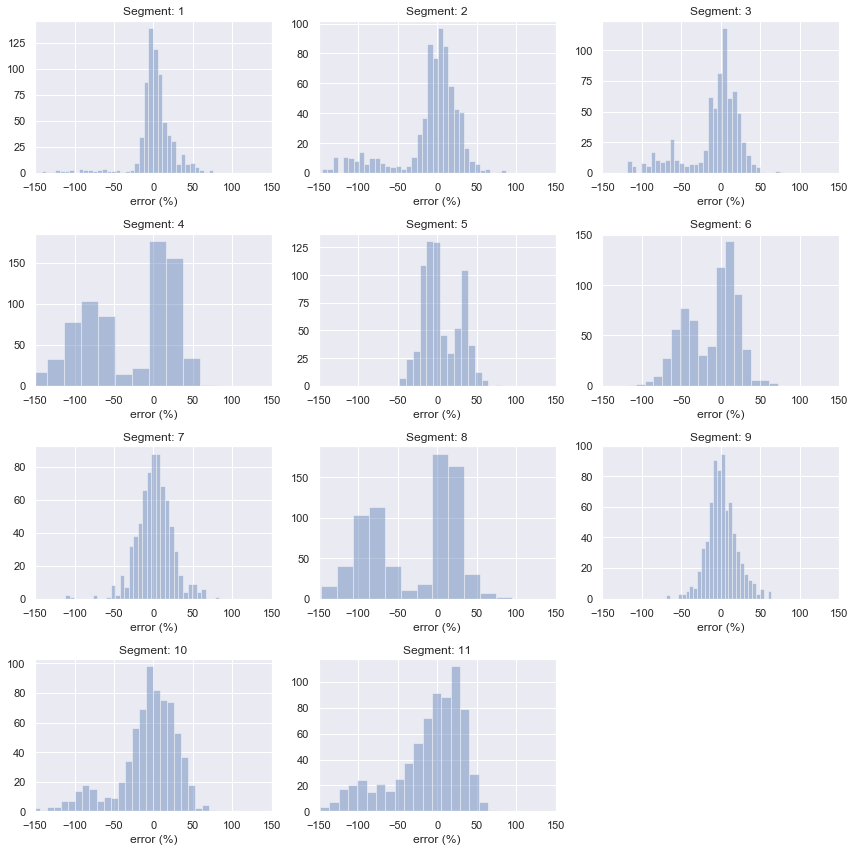

In [35]:
fig, axes = plt.subplots(4, 3, figsize=(12,12))
for i, ax in enumerate(axes.flatten()):
    _=sns.distplot(error_df[(error_df.segment == i+1) & (error_df.slice == '20_p')].error_p, kde=False, ax=ax)
    ax.set_title(f'Segment: {i+1}')
    ax.set_xlabel('error (%)')
    ax.set_xlim(-150, 150)
fig.delaxes(ax)
plt.tight_layout()
plt.show()

#### Errors in seconds

/home/max/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/max/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/max/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


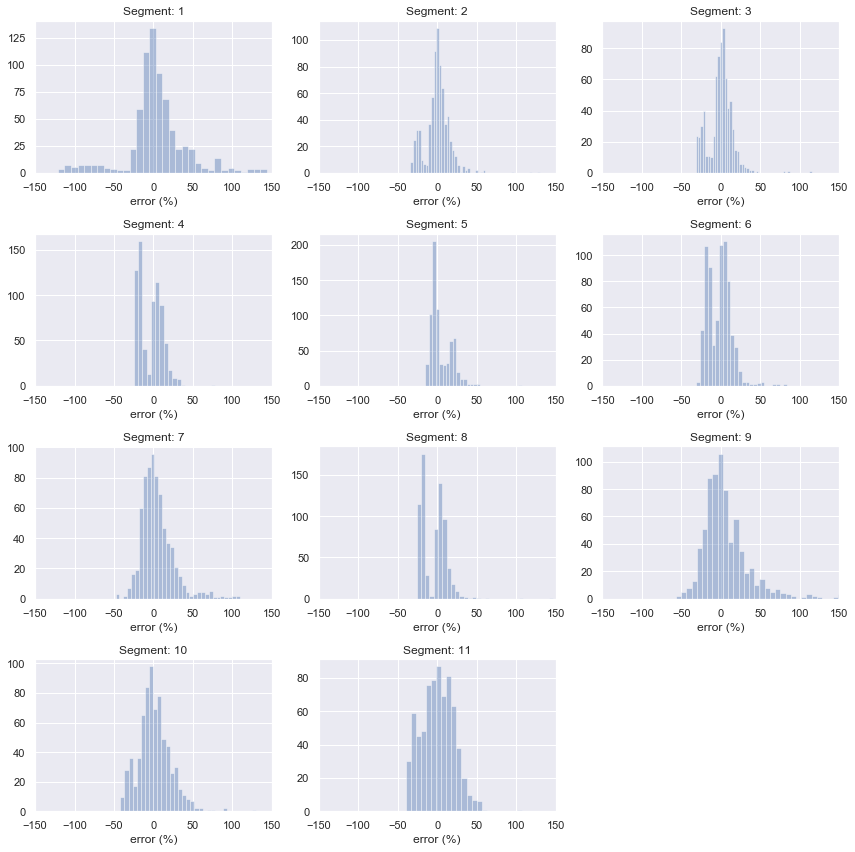

In [36]:
fig, axes = plt.subplots(4, 3, figsize=(12,12))
for i, ax in enumerate(axes.flatten()):
    _=sns.distplot(error_df[(error_df.segment == i+1) & (error_df.slice == '20_p')].error_s, kde=False, ax=ax)
    ax.set_title(f'Segment: {i+1}')
    ax.set_xlabel('error (%)')
    ax.set_xlim(-150, 150)
fig.delaxes(ax)
plt.tight_layout()
plt.show()